In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from scipy import signal
from scipy.signal import find_peaks
from sklearn import linear_model
from os import listdir
%matplotlib inline


path = "data/Images/Test/"

In [2]:
def getResizedImage(fileName, scale_percent=20):
    img = cv2.imread(path + fileName)
    # Resize
#     print('Original Dimensions : ',img.shape)
#     scale_percent = 20 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized_image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    # Change COLOR mode
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    
    return rgb_image

In [3]:
def preprocessImage(image, low_threshold = 100, high_threshold = 250):
    kernel = np.ones((3,3),np.float32)/9
    dst = cv2.filter2D(image,-1,kernel)
    
    img_dilation = cv2.dilate(dst, kernel, iterations=3)
    img_erosion2 = cv2.erode(img_dilation, kernel, iterations=3)
    
#     low_threshold = 100
#     high_threshold = 250
    edges = cv2.Canny(img_erosion2, low_threshold, high_threshold)

#     plt.imshow(edges, cmap="gray")
#     plt.show()
    
    sobelx = cv2.Sobel(src=edges, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
    sobely = cv2.Sobel(src=edges, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
    
    temp = cv2.bitwise_and(sobelx, sobely)
    
    return temp

In [4]:
def detectDataPoint(img):
    Y_coor = []
    lefts = []
    rights = []

    y = img.shape[0] - 1
    while y >= 0:
        if (len(lefts) >= 10):
            break
        horizontal_pixels = img[y,:]
        if (horizontal_pixels.min() >=0):
            y -= 1
            continue
        else:
            leftPos = np.argmin(horizontal_pixels)
            if (horizontal_pixels[leftPos:].max() <= 0):
                y -= 1
                continue
            else:
                rightPos = leftPos + np.argmax(horizontal_pixels[leftPos:])
                if rightPos - leftPos > 100:
                    # Add pairs
                    Y_coor.append(y)
                    lefts.append(leftPos)
                    rights.append(rightPos)
        ### update 
        y -= 10
    
    return Y_coor, lefts, rights

In [5]:
def fitRANSAC(Y_coor, lefts, rights): 
    # Y data
    Y_data = np.array(Y_coor).reshape(-1, 1)


    # Left line
    X_left = np.array(lefts).reshape(-1, 1)

    # Right line
    X_right = np.array(rights).reshape(-1, 1)

    # Robustly fit linear model with RANSAC algorithm
    ransacLeft = linear_model.RANSACRegressor()
    ransacLeft.fit(Y_data, X_left)
    ransacRight = linear_model.RANSACRegressor()
    ransacRight.fit(Y_data, X_right)
    
    return ransacLeft, ransacRight

def outputFrame(image, ransacLeft, ransacRight):
    copy3 = image.copy()
    theme = 255 * np.ones_like(image)
    # Calculate interception
    a1 = ransacLeft.estimator_.coef_
    b1 = ransacLeft.estimator_.intercept_

    a2 = ransacRight.estimator_.coef_
    b2 = ransacRight.estimator_.intercept_

    # a1 * Y1 + b1 = X1
    # a2 * Y1 + b2 = X1

    Y_intercept = (b2-b1) / (a1 - a2)
    X_intercept = a1 * Y_intercept + b1 

    for i in range(copy3.shape[0]):
        if i < int(Y_intercept):
            continue
        leftDot  = int(ransacLeft.predict(np.array([[i]])))
        rightDot = int(ransacRight.predict(np.array([[i]])))
        if  leftDot <  copy3.shape[1] and leftDot >= 0:
            copy3[i, leftDot] = [255, 0, 0]
            theme[i, leftDot] = [0, 0, 0]
        if  rightDot <  copy3.shape[1] and rightDot >= 0:
            copy3[i, rightDot] = [255, 0, 0]
            theme[i, rightDot] = [0, 0, 0]
        if np.abs(rightDot - leftDot) < 1:
            print(f"Intercept at [{leftDot}/{rightDot}, {i}]")
    
    return [X_intercept, Y_intercept], copy3, theme

def plotFrame(intercept, copy3, theme):
    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(copy3)
    # plt.axis('off')

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # for i in range(len(lefts)):
    #     plt.scatter(lefts[i], Y_coor[i], color='blue')
    # plt.plot([X_intercept, 100 + theme.shape[1]/2], [Y_intercept, theme.shape[1]], color="red", linewidth=3)
    plt.scatter(intercept[0], intercept[1], color='blue')
    plt.plot([theme.shape[1]/2,  theme.shape[1]/2], [0, theme.shape[1]], color="red", linewidth=3)
    plt.imshow(theme)
    plt.show()
    
def response(intercept):
    if (np.abs(intercept[0] - 400) < 50):
        print("No adjustment")
    elif (intercept[0] - 400 < 0):
        print("Adjust to the left")
    else: 
        print("Adjust to the right")

### DEMO


[Picture 1]


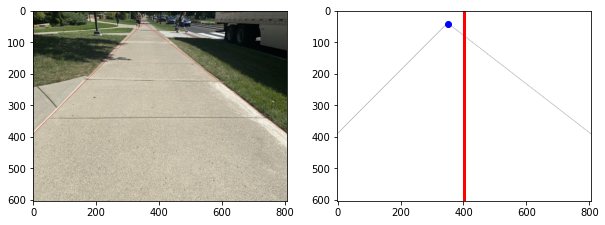

No adjustment


In [6]:
counter = 1
for fileName in listdir(path)[0:1]:
    print(f"\n[Picture {counter}]")
    counter += 1
    ### Get Image
    rgb_image = getResizedImage(fileName)

    ### Preprocess Image
    temp = preprocessImage(rgb_image)

    ### Detect data points
    Y_coor, lefts, rights = detectDataPoint(temp)

    ### Fit Ransac
    ransacLeft, ransacRight =  fitRANSAC(Y_coor, lefts, rights)

    ### Output Frame
    intercept, outFrame, theme =  outputFrame(rgb_image, ransacLeft, ransacRight)

    ### Plot
    plotFrame(intercept, outFrame, theme)

    ### Answer
    response(intercept)

In [7]:
float(intercept[0])

351.02803744014466

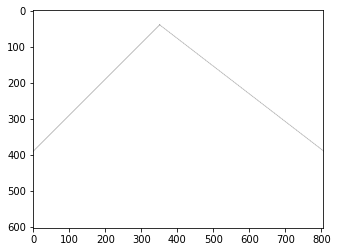

In [8]:
plt.imshow(theme)

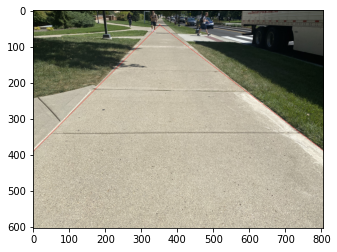

In [9]:
plt.imshow(outFrame)

In [10]:
# plt.scatter(intercept[0], intercept[1], color='blue')
# plt.plot([theme.shape[1]/2,  theme.shape[1]/2], [0, theme.shape[1]], color="red", linewidth=3)
# plt.imshow(theme)

tmp = cv2.circle(outFrame, (int(intercept[0]), int(intercept[1])), radius=0, color=(0, 0, 255), thickness=20)
tmpImg = cv2.line(tmp, (403, 604), (403, 0), color=(255, 0, 0), thickness=3)

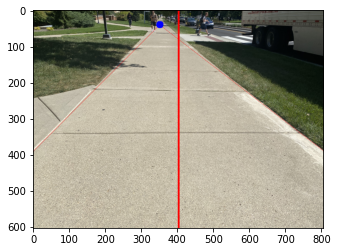

In [11]:
plt.imshow(tmpImg)